In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import joblib

# Load the dataset
# Replace 'file_path.csv' with your dataset path
df = pd.read_csv("fraudTrain.csv")

# Preview the dataset
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [2]:
# Problem statement: Identify fraudulent transactions based on available features.

# Target variable
target = 'is_fraud'

# Features (drop irrelevant columns)
features = ['amt', 'category', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']

# Drop rows where the target variable 'is_fraud' has NaN values
df = df.dropna(subset=[target])

# Check for NaN values in the features and drop those rows
df = df.dropna(subset=features)

# Check class imbalance
print(df[target].value_counts())

# If needed, you can also print out the ratio of the classes
print(f"Class imbalance ratio: {df[target].value_counts(normalize=True)}")


is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Class imbalance ratio: is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


In [3]:
# Split the dataset into 80% training and 20% testing
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 1037340
Testing set size: 259335


In [4]:
# Preprocessing: Handle categorical and numerical features
numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']
categorical_features = ['category']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing to training data only
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Resampled training set size: {X_train_resampled.shape[0]}")


Resampled training set size: 2062670


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Logistic Regression

In [6]:
lr_params = {
    'max_iter': [500, 1000],
    'C': [0.1, 1.0, 10.0],
    'class_weight': ['balanced']
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train_resampled, y_train_resampled)
best_lr = lr_grid.best_estimator_

y_pred_lr = best_lr.predict(X_test_preprocessed)
y_proba_lr = best_lr.predict_proba(X_test_preprocessed)[:, 1]
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

# Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train_resampled, y_train_resampled)
best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test_preprocessed)
if hasattr(best_dt, "predict_proba"):
    y_proba_dt = best_dt.predict_proba(X_test_preprocessed)[:, 1]
    roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
else:
    roc_auc_dt = None
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test_preprocessed)
y_proba_rf = best_rf.predict_proba(X_test_preprocessed)[:, 1]
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Gradient Boosting

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='roc_auc', n_jobs=-1)
gb_grid.fit(X_train_resampled, y_train_resampled)
best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test_preprocessed)
y_proba_gb = best_gb.predict_proba(X_test_preprocessed)[:, 1]
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)

# Bayesian Classifier (Naive Bayes)

In [11]:
from sklearn.naive_bayes import GaussianNB

gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

gnb_grid = GridSearchCV(GaussianNB(), gnb_params, cv=5, scoring='roc_auc', n_jobs=-1)
gnb_grid.fit(X_train_resampled, y_train_resampled)
best_gnb = gnb_grid.best_estimator_

y_pred_gnb = best_gnb.predict(X_test_preprocessed)
y_proba_gnb = best_gnb.predict_proba(X_test_preprocessed)[:, 1]
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
roc_auc_gnb = roc_auc_score(y_test, y_proba_gnb)
report_gnb = classification_report(y_test, y_pred_gnb, output_dict=True)

 # Hidden Markov Model (HMM) for Classification

In [12]:
from hmmlearn.hmm import GaussianHMM

# Perform a manual grid search on n_components
best_hmm_score = -np.inf
best_n_components = None
for n in [2, 3, 4]:
    hmm0 = GaussianHMM(n_components=n, covariance_type="diag", random_state=42)
    hmm1 = GaussianHMM(n_components=n, covariance_type="diag", random_state=42)
    X_train_class0 = X_train_resampled[y_train_resampled == 0]
    X_train_class1 = X_train_resampled[y_train_resampled == 1]
    try:
        hmm0.fit(X_train_class0)
        hmm1.fit(X_train_class1)
    except Exception as ex:
        continue
    scores = []
    for sample in X_test_preprocessed:
        sample = sample.reshape(1, -1)
        score0 = hmm0.score(sample)
        score1 = hmm1.score(sample)
        scores.append(max(score0, score1))
    avg_score = np.mean(scores)
    if avg_score > best_hmm_score:
        best_hmm_score = avg_score
        best_n_components = n

# Fit final HMMs using best_n_components
hmm0 = GaussianHMM(n_components=best_n_components, covariance_type="diag", random_state=42)
hmm1 = GaussianHMM(n_components=best_n_components, covariance_type="diag", random_state=42)
X_train_class0 = X_train_resampled[y_train_resampled == 0]
X_train_class1 = X_train_resampled[y_train_resampled == 1]
hmm0.fit(X_train_class0)
hmm1.fit(X_train_class1)

def predict_hmm(sample):
    if sample.ndim == 1:
        sample = sample.reshape(1, -1)
    score0 = hmm0.score(sample)
    score1 = hmm1.score(sample)
    return 0 if score0 > score1 else 1

y_pred_hmm = np.array([predict_hmm(sample) for sample in X_test_preprocessed])
accuracy_hmm = accuracy_score(y_test, y_pred_hmm)
report_hmm = classification_report(y_test, y_pred_hmm, output_dict=True)
roc_auc_hmm = None  # Not applicable

In [20]:
def extract_metrics(report):
    # Dynamically pick the key that is not in average metrics
    key = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']][0]
    return {
        "Accuracy": report['accuracy'] if 'accuracy' in report else None,
        "Precision": report[key]['precision'],
        "Recall": report[key]['recall'],
        "F1-Score": report[key]['f1-score']
    }

results = {
    "Logistic Regression": {
        "Accuracy": accuracy_lr,
        "ROC-AUC": roc_auc_lr,
        **extract_metrics(report_lr)
    },
    "Decision Tree": {
        "Accuracy": accuracy_dt,
        "ROC-AUC": roc_auc_dt,
        **extract_metrics(report_dt)
    },
    "Random Forest": {
        "Accuracy": accuracy_rf,
        "ROC-AUC": roc_auc_rf,
        **extract_metrics(report_rf)
    },
    "Gradient Boosting": {
        "Accuracy": accuracy_gb,
        "ROC-AUC": roc_auc_gb,
        **extract_metrics(report_gb)
    },
    "Gaussian Naive Bayes": {
        "Accuracy": accuracy_gnb,
        "ROC-AUC": roc_auc_gnb,
        **extract_metrics(report_gnb)
    },
    "Hidden Markov Model": {
        "Accuracy": accuracy_hmm,
        "ROC-AUC": roc_auc_hmm,
        **extract_metrics(report_hmm)
    }
}

print("Final Results Matrix:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")
        else:
            print(f"{metric}: N/A")



Final Results Matrix:

Logistic Regression:
Accuracy: 0.8846
ROC-AUC: 0.9058
Precision: 0.9984
Recall: 0.8853
F1-Score: 0.9385

Decision Tree:
Accuracy: 0.9778
ROC-AUC: 0.9513
Precision: 0.9994
Recall: 0.9783
F1-Score: 0.9887

Random Forest:
Accuracy: 0.9959
ROC-AUC: 0.9920
Precision: 0.9990
Recall: 0.9969
F1-Score: 0.9979

Gradient Boosting:
Accuracy: 0.9728
ROC-AUC: 0.9921
Precision: 0.9996
Recall: 0.9730
F1-Score: 0.9861

Gaussian Naive Bayes:
Accuracy: 0.5925
ROC-AUC: 0.8116
Precision: 0.9978
Recall: 0.5914
F1-Score: 0.7426

Hidden Markov Model:
Accuracy: 0.3245
ROC-AUC: N/A
Precision: 0.9875
Recall: 0.3247
F1-Score: 0.4887


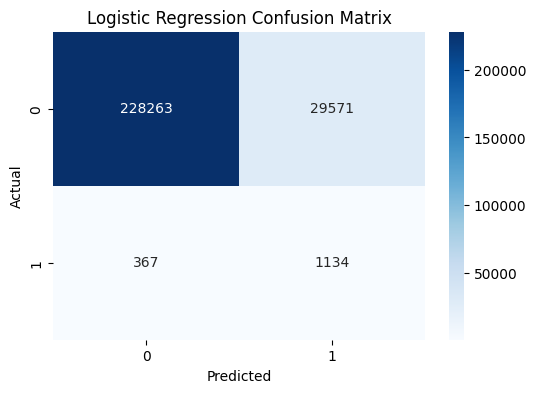

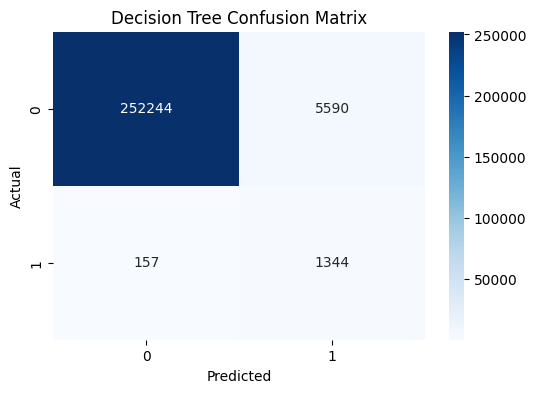

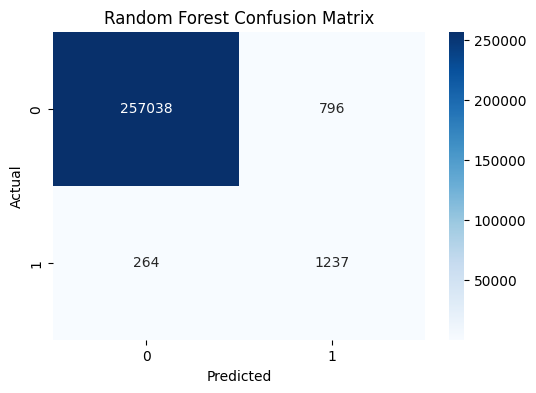

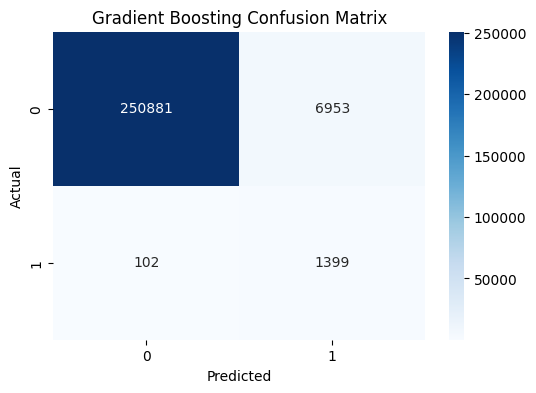

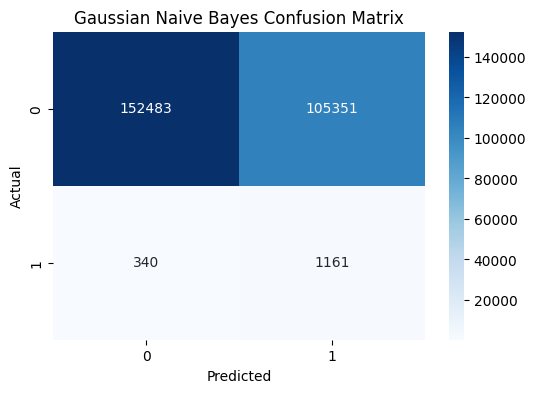

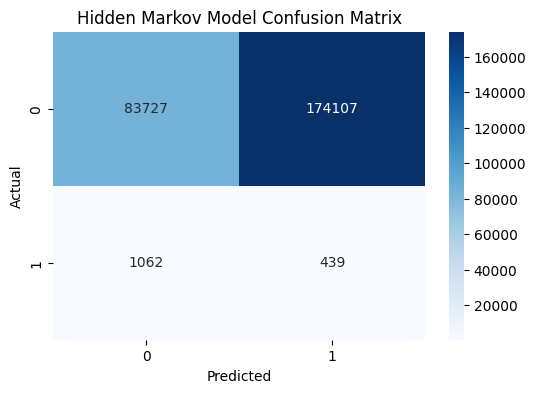

<Figure size 640x480 with 0 Axes>

In [29]:
# ==========================
# Plotting Confusion Matrices
# ==========================
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_conf_matrix(y_test, y_pred_dt, "Decision Tree Confusion Matrix")
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_conf_matrix(y_test, y_pred_gb, "Gradient Boosting Confusion Matrix")
plot_conf_matrix(y_test, y_pred_gnb, "Gaussian Naive Bayes Confusion Matrix")
plot_conf_matrix(y_test, y_pred_hmm, "Hidden Markov Model Confusion Matrix")
plt.savefig("1.jpg")
plt.savefig("2.jpg")
plt.savefig("3.jpg")
plt.savefig("4.jpg")
plt.savefig("5.jpg")
plt.savefig("6.jpg")

In [49]:
import pandas as pd

# Define the performance metrics for each model
performance_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Gaussian Naive Bayes', 'Hidden Markov Model'],
    'Accuracy': [0.8846, 0.9778, 0.9959, 0.9728, 0.5925, 0.3245],
    'ROC-AUC': [0.9058, 0.9513, 0.9920, 0.9921, 0.8116, None],  # ROC-AUC is not applicable for HMM
    'Precision': [0.9984, 0.9994, 0.9990, 0.9996, 0.9978, 0.9875],
    'Recall': [0.8853, 0.9783, 0.9969, 0.9730, 0.5914, 0.3247],
    'F1-Score': [0.9385, 0.9887, 0.9979, 0.9861, 0.7426, 0.4887]
}

# Create a DataFrame
performance_df = pd.DataFrame(performance_data)

# Display the DataFrame
print(performance_df)


                  Model  Accuracy  ROC-AUC  Precision  Recall  F1-Score
0   Logistic Regression    0.8846   0.9058     0.9984  0.8853    0.9385
1         Decision Tree    0.9778   0.9513     0.9994  0.9783    0.9887
2         Random Forest    0.9959   0.9920     0.9990  0.9969    0.9979
3     Gradient Boosting    0.9728   0.9921     0.9996  0.9730    0.9861
4  Gaussian Naive Bayes    0.5925   0.8116     0.9978  0.5914    0.7426
5   Hidden Markov Model    0.3245      NaN     0.9875  0.3247    0.4887


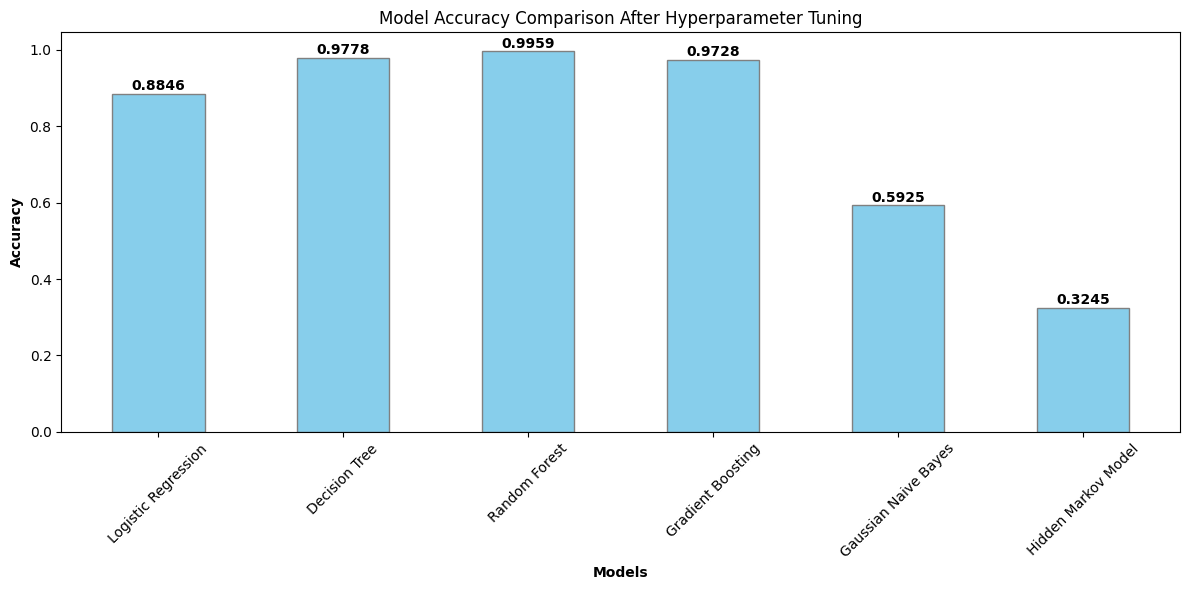

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and their corresponding Accuracy values from your matrix
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Gaussian Naive Bayes', 'Hidden Markov Model']
accuracy = [0.8846, 0.9778, 0.9959, 0.9728, 0.5925, 0.3245]

# Set bar width
bar_width = 0.5
x_pos = np.arange(len(models))

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(x_pos, accuracy, color='skyblue', width=bar_width, edgecolor='grey')

# Add labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(x_pos, models, rotation=45)
plt.title('Model Accuracy Comparison After Hyperparameter Tuning')

# Manually add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig("accuracy_chart.jpg")


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Define numerical and categorical features
numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time']
categorical_features = ['category']

# Create preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Initialize the best model
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])


In [33]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'city_pop', 'lat',
                                                   'long', 'merch_lat',
                                                   'merch_long', 'unix_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['category'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

In [34]:
from sklearn.metrics import f1_score

y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.7274


In [39]:
import joblib

joblib.dump(pipeline, 'best_fraud_detection_pipeline1.1.pkl')
print("Pipeline saved successfully!")


Pipeline saved successfully!


In [44]:
loaded_pipeline = joblib.load('best_fraud_detection_pipeline1.1.pkl')


sample_data = pd.read_csv("sample_test.csv")  # Replace with actual data
prediction = loaded_pipeline.predict(sample_data)
print(f"Predicted class: {prediction[0]}")


Predicted class: 0
